In [ ]:
import pandas as pd
import numpy as np

normal_path = "BC-TCGA-Normal.txt"  
tumor_path  = "BC-TCGA-Tumor.txt"   

df_normal = pd.read_csv(normal_path, sep='\t')
df_tumor  = pd.read_csv(tumor_path,  sep='\t')

df_normal = df_normal.set_index(df_normal.columns[0])
df_tumor  = df_tumor.set_index(df_tumor.columns[0])

print("Normal shape:", df_normal.shape)
print("Tumor shape :", df_tumor.shape)

common_genes = df_normal.index.intersection(df_tumor.index)
df_normal = df_normal.loc[common_genes]
df_tumor  = df_tumor.loc[common_genes]

df_all = pd.concat([df_normal, df_tumor], axis=1)

# Transpose so rows = samples, columns = genes (more scikit-learn friendly)
X = df_all.T

# Create labels: 0 for normal, 1 for tumor
labels = np.array([0]*df_normal.shape[1] + [1]*df_tumor.shape[1])

print("Combined matrix shape:", X.shape)  # (samples, genes)
print("Labels shape:", labels.shape)


Normal shape: (17814, 61)
Tumor shape : (17814, 529)
Combined matrix shape: (590, 17814)
Labels shape: (590,)


# 2. Preprocessing

Plan
Standardize per gene (z-score).
Compute variance of each gene across all samples.
Select top N (e.g., 2000) most variable genes.

In [ ]:
# Fill NaNs with the gene's mean across samples
import numpy as np

# Before StandardScaler:
X_filled = X.fillna(X.mean())

# Then standardize:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_filled)

variances = X_std.var(axis=0)
top_n = 2000
top_indices = np.argsort(variances)[::-1][:top_n]
X_top = X_std[:, top_indices]


In [30]:
n_normal = 61
n_tumor = 529

# create label array: 0 for normal, 1 for tumor
y = np.array([0]*n_normal + [1]*n_tumor)

print(y.shape, np.bincount(y))

(590,) [ 61 529]


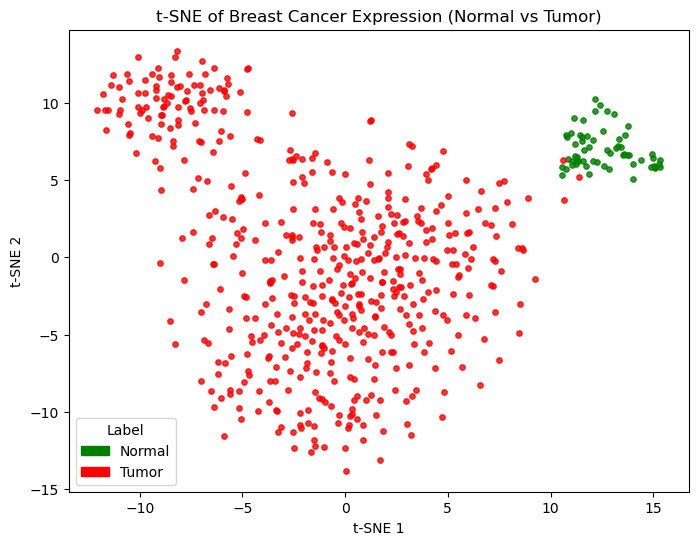

In [ ]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Run t-SNE on the top genes
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto')
X_embedded = tsne.fit_transform(X_top)

# Create a boolean mask for each class
normal_mask = (y == 0)  # adjust depending on your label encoding
tumor_mask  = (y == 1)

plt.figure(figsize=(8,6))

# Plot each group separately with its own color
plt.scatter(X_embedded[normal_mask, 0],
            X_embedded[normal_mask, 1],
            c='green', s=15, alpha=0.8, label='Normal')

plt.scatter(X_embedded[tumor_mask, 0],
            X_embedded[tumor_mask, 1],
            c='red', s=15, alpha=0.8, label='Tumor')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Breast Cancer Expression (Normal vs Tumor)')

# Explicit legend patches to ensure correct colors
normal_patch = mpatches.Patch(color='green', label='Normal')
tumor_patch  = mpatches.Patch(color='red', label='Tumor')
plt.legend(handles=[normal_patch, tumor_patch], title='Label')

plt.show()


# Clustering

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import pandas as pd

# pca on top genes
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_top)

print("X_pca shape:", X_pca.shape)
print("Explained variance by first 50 PCs:", pca.explained_variance_ratio_.sum())

# k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

print("Cluster assignments shape:", clusters.shape)

# Compare with true labels
print("Confusion matrix (clusters vs. true labels):")
print(confusion_matrix(y, clusters))

print("Adjusted Rand Index (ARI):", adjusted_rand_score(y, clusters))


X_pca shape: (590, 50)
Explained variance by first 50 PCs: 0.6050064408575504
Cluster assignments shape: (590,)
Confusion matrix (clusters vs. true labels):
[[  2  59]
 [118 411]]
Adjusted Rand Index (ARI): -0.07945492530621841


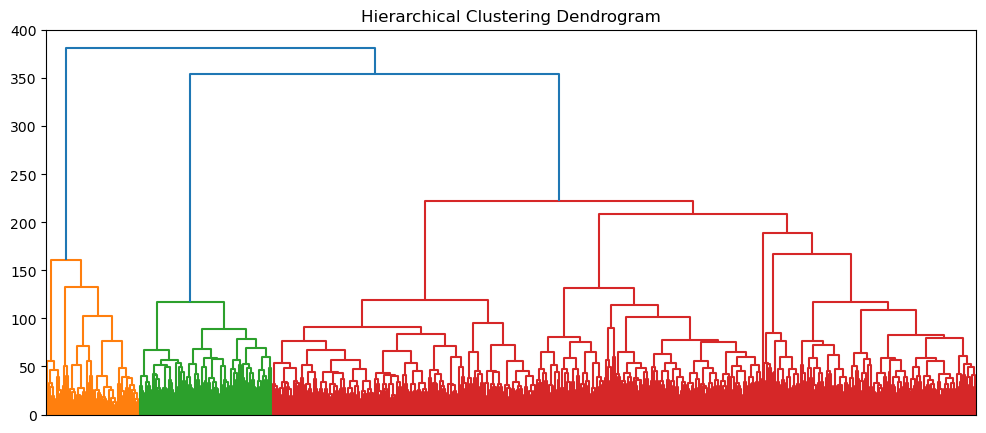

In [33]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# compute linkage matrix on PCA data
Z = linkage(X_pca, method='ward')

# plot dendrogram (optional)
plt.figure(figsize=(12,5))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# cut the tree at k=2 clusters
clusters_h = fcluster(Z, t=2, criterion='maxclust')


Explained variance by first 50 PCs: 0.6050064408575504


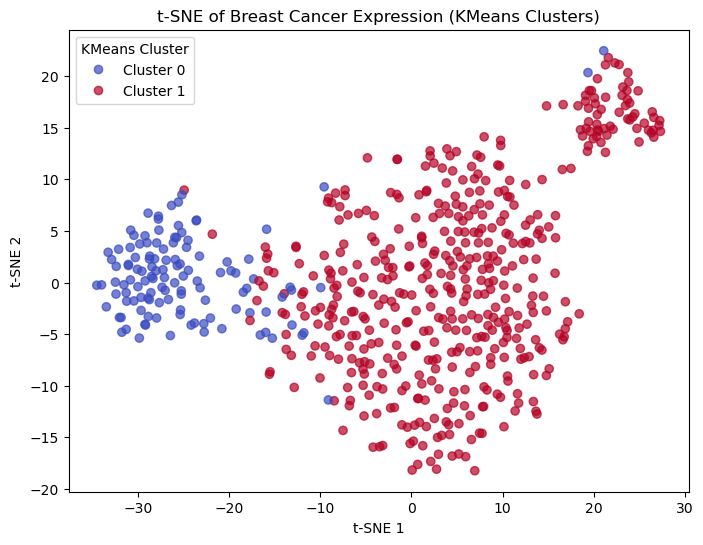

Confusion matrix (clusters vs. true labels):
[[  2  59]
 [118 411]]
Adjusted Rand Index (ARI): -0.07945492530621841


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_top)
print("Explained variance by first 50 PCs:", pca.explained_variance_ratio_.sum())

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)  # changed n_iter to max_iter
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1],
                      c=clusters, cmap='coolwarm', alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of Breast Cancer Expression (KMeans Clusters)")
plt.legend(handles=scatter.legend_elements()[0],
           labels=["Cluster 0","Cluster 1"], title="KMeans Cluster")
plt.show()

print("Confusion matrix (clusters vs. true labels):")
print(confusion_matrix(y, clusters))

print("Adjusted Rand Index (ARI):", adjusted_rand_score(y, clusters))

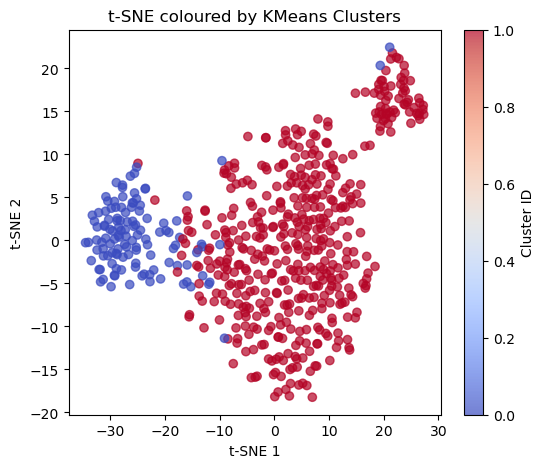

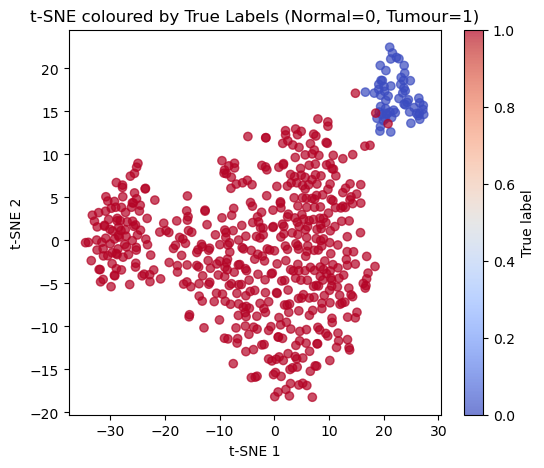

Adjusted Rand Index (ARI): -0.079
Silhouette Score: 0.160


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score

plt.figure(figsize=(6,5))
scatter1 = plt.scatter(X_tsne[:,0], X_tsne[:,1],
                       c=clusters, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE coloured by KMeans Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter1, label="Cluster ID")
plt.show()

plt.figure(figsize=(6,5))
scatter2 = plt.scatter(X_tsne[:,0], X_tsne[:,1],
                       c=y, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE coloured by True Labels (Normal=0, Tumour=1)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter2, label="True label")
plt.show()

ari = adjusted_rand_score(y, clusters)
silhouette = silhouette_score(X_pca, clusters)  # use PCA space for silhouette

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Silhouette Score: {silhouette:.3f}")


In [36]:
import numpy as np
import pandas as pd

# cluster IDs (0/1)
cluster_ids = np.unique(clusters)

# average expression for each gene in each cluster
cluster_means = []
for cid in cluster_ids:
    cluster_means.append(X_top[clusters==cid].mean(axis=0))
cluster_means = np.array(cluster_means)  # shape (2, 2000)

# difference between clusters (absolute)
diff = np.abs(cluster_means[0] - cluster_means[1])

# indices of top 20 most different genes
top_gene_idx = np.argsort(diff)[::-1][:20]


In [ ]:
# subset the expression matrix to the top genes
X_heatmap = X_top[:, top_gene_idx]

gene_names = X.columns[top_indices][top_gene_idx]


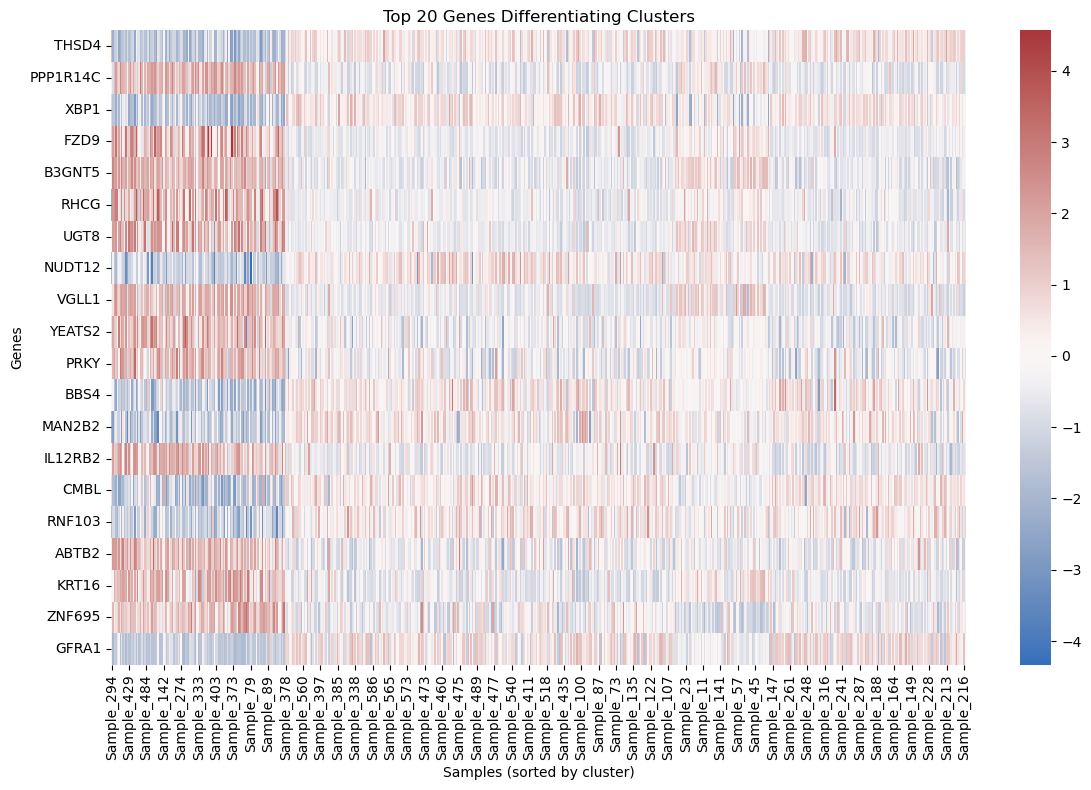

In [ ]:
X_heatmap = X_top[:, top_gene_idx]

# get gene names from columns of your original DataFrame
gene_names = X.columns[top_indices][top_gene_idx]

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

heatmap_df = pd.DataFrame(
    X_heatmap,
    columns=gene_names,
    index=[f"Sample_{i}" for i in range(X_heatmap.shape[0])]
)

order = np.argsort(clusters)
heatmap_df = heatmap_df.iloc[order, :]

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_df.T, cmap='vlag', center=0)
plt.title("Top 20 Genes Differentiating Clusters")
plt.xlabel("Samples (sorted by cluster)")
plt.ylabel("Genes")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

cluster_means_dict = {}
for cid in np.unique(clusters):
    cluster_means_dict[f"Cluster_{cid}_mean"] = X_top[clusters==cid][:, top_gene_idx].mean(axis=0)

gene_names = X.columns[top_indices][top_gene_idx] 
cluster_means_df = pd.DataFrame(cluster_means_dict, index=gene_names)

if cluster_means_df.shape[1] == 2:
    cluster_means_df["abs_diff"] = np.abs(
        cluster_means_df.iloc[:,0] - cluster_means_df.iloc[:,1]
    )

# save to CSV
cluster_means_df.to_csv("top20_gene_means.csv")
print("Saved top-20 gene means per cluster to top20_gene_means.csv")


Saved top-20 gene means per cluster to top20_gene_means.csv
